# Generating captions from Flickr-30K feature embeddings
This notebook generates captions from the Flickr-30K dataset. This allows us to analyze the quality of captions generated by the LSTM we trained in the `Train.ipynb` notebook. Unfortunately, we can not see the images associated with the Feature embedding. For that please look at the `Generate.ipynb` notebook.

*Note:* The `model_path` variable should be the same as the `model_path` variable set in `Test.ipynb`

** Train for at least 1 epoch before running the caption generator! **

In [1]:
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import cv2

import tensorflow.python.platform
from keras.preprocessing import sequence
from collections import Counter

Using TensorFlow backend.


# Downloading Data
As mentioned in the README, in order to run this notebook, you will need VGG-16 image embeddings for the Flickr-30K dataset. These image embeddings are available from our [Google Drive](https://drive.google.com/file/d/0B5o40yxdA9PqTnJuWGVkcFlqcG8/view?usp=sharing).

Additionally, you will need the corresponding captions for these images (`results_20130124.token`), which can also be downloaded from our [Google Drive](https://drive.google.com/file/d/0B2vTU3h54lTydXFjSVM5T2t4WmM/view?usp=sharing).

(**Note**: These are the same downloads from `O'Reilly Training.ipynb`. If you downloaded them while working through that notebook there is no need to download them again)

Place all of these downloads in the `./data/` folder.

The feature embeddings will be in `./data/feats.npy` and the embeddings' corresponding captions will be saved to `./data/results_20130124.token` .

In [2]:
model_path = './models/tensorflow'
feature_path = './data/feats.npy'
annotation_path = './data/results_20130124.token'
flickr_30k_path = "./data/flickr30k/flickr30k_images"

In [3]:
### Set Hyperparameters ###
dim_embed = 256
dim_hidden = 256
dim_in = 4096
batch_size = 1
learning_rate = 0.001
momentum = 0.9
n_epochs = 25

In [4]:
# read in the embeddings
def get_data(annotation_path, feature_path): 
     annotations = pd.read_table(annotation_path, sep='\t', header=None, names=['image', 'caption'])
     return np.load(feature_path,'r'), annotations['caption'].values,  [s[:-2] for s in annotations['image'].values]

## Some statistics for our captions

In [5]:
feats, captions, images = get_data(annotation_path, feature_path)

In [6]:
images[0:5]

['1000092795.jpg',
 '1000092795.jpg',
 '1000092795.jpg',
 '1000092795.jpg',
 '1000092795.jpg']

In [7]:
from collections import defaultdict
print('%s image embeddings' % str(feats.shape) )
print('%s captions\n' % str(captions.shape) )

capt_per_img = defaultdict(list)
for i,c in zip(images, captions):
    capt_per_img[i].append(c)

num_capt_per_img = {i:len(c) for i,c in capt_per_img.iteritems()}

(158915, 4096) image embeddings
(158915,) captions



In [8]:
print('Mean: {} captions/sentences per image'.format(np.mean(num_capt_per_img.values()) ) )
print('Mean: {:.1f} characters per caption'.format(np.mean( [len(c) for c in captions] ) ))

Mean: 5.0 captions/sentences per image
Mean: 64.2 characters per caption


In [9]:
# Show all captions for an image
for i in list(capt_per_img.keys())[0:1]:
    print(capt_per_img[i])

['A man in jeans is reclining on a green metal bench along a busy sidewalk and crowded street .', 'A white male with a blue sweater and gray pants laying on a sidewalk bench .', 'A man in a blue shirt and gray pants is sleeping on a sidewalk bench .', 'A person is sleeping on a bench , next to cars .', 'A man sleeping on a bench in a city area .']


Chosen image 20486.
Amid the mountains a young man , wearing a white top , dark pants and a dark blue scarf , stands atop a rock .


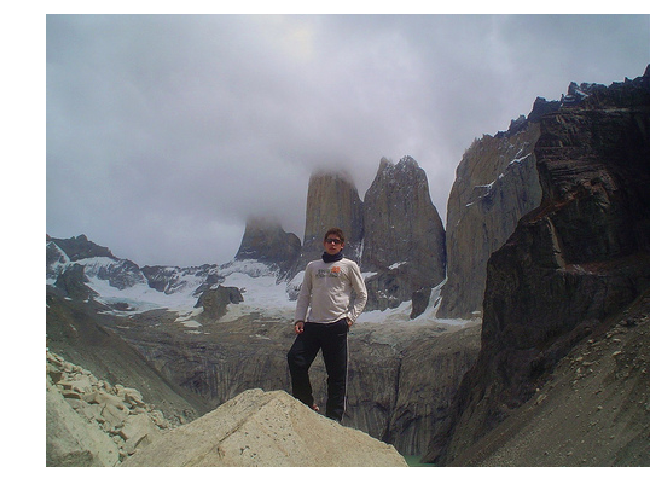

./data/flickr30k/flickr30k_images/2212794589.jpg


In [10]:
def show_image(image_path):
    # load the image, convert it to grayscale, and show it
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(8,6), dpi=100)
    plt.axis('off')
    plt.imshow(cv2.cvtColor( np.squeeze(img), cv2.COLOR_BGR2RGB))
    plt.show()

# randomly show some image
rnd = np.random.randint(0, len(captions)-1)
print('Chosen image {}.'.format(rnd))
print(captions[rnd])
img_path = os.path.join(flickr_30k_path, images[rnd])
show_image(img_path)
print(img_path)

In [11]:
class Caption_Generator():
    def __init__(self, dim_in, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, init_b=None):

        self.dim_in = dim_in
        self.dim_embed = dim_embed
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.n_lstm_steps = n_lstm_steps
        self.n_words = n_words
        
        # declare the variables to be used for our word embeddings
        with tf.device("/cpu:0"):
            self.word_embedding = tf.Variable(tf.random_uniform([self.n_words, self.dim_embed], -0.1, 0.1), name='word_embedding')

        self.embedding_bias = tf.Variable(tf.zeros([dim_embed]), name='embedding_bias')
        
        # declare the LSTM itself
        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden)
        
        # declare the variables to be used to embed the image feature embedding to the word embedding space
        self.img_embedding = tf.Variable(tf.random_uniform([dim_in, dim_hidden], -0.1, 0.1), name='img_embedding')
        self.img_embedding_bias = tf.Variable(tf.zeros([dim_hidden]), name='img_embedding_bias')

        # declare the variables to go from an LSTM output to a word encoding output
        self.word_encoding = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='word_encoding')
        
        # optional initialization setter for encoding bias variable 
        if init_b is not None:
            self.word_encoding_bias = tf.Variable(init_b, name='word_encoding_bias')
        else:
            self.word_encoding_bias = tf.Variable(tf.zeros([n_words]), name='word_encoding_bias')

    def build_model(self):
        # declaring the placeholders for our extracted image feature vectors, our caption, and our mask
        # (describes how long our caption is with an array of 0/1 values of length `maxlen`  
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        caption_placeholder = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])
        
        # getting an initial LSTM embedding from our image_imbedding
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        
        # setting initial state of our LSTM
        state = self.lstm.zero_state(self.batch_size, dtype=tf.float32)

        total_loss = 0.0
        with tf.variable_scope("RNN"):
            for i in range(self.n_lstm_steps): 
                if i > 0:
                   # if this isn’t the first iteration of our LSTM we need to get the word_embedding corresponding
                   # to the (i-1)th word in our caption 
                    with tf.device("/cpu:0"):
                        current_embedding = tf.nn.embedding_lookup(self.word_embedding, caption_placeholder[:,i-1]) + self.embedding_bias
                else:
                     #if this is the first iteration of our LSTM we utilize the embedded image as our input 
                    current_embedding = image_embedding
                if i > 0: 
                    # allows us to reuse the LSTM tensor variable on each iteration
                    tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(current_embedding, state)

                
                if i > 0:
                    #get the one-hot representation of the next word in our caption 
                    labels = tf.expand_dims(caption_placeholder[:, i], 1)
                    ix_range=tf.range(0, self.batch_size, 1)
                    ixs = tf.expand_dims(ix_range, 1)
                    concat = tf.concat([ixs, labels],1)
                    onehot = tf.sparse_to_dense(
                            concat, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0)


                    #perform a softmax classification to generate the next word in the caption
                    logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=onehot)
                    xentropy = xentropy * mask[:,i]

                    loss = tf.reduce_sum(xentropy)
                    total_loss += loss

            total_loss = total_loss / tf.reduce_sum(mask[:,1:])
            return total_loss, img,  caption_placeholder, mask


    def build_generator(self, maxlen, batchsize=1):
        #same setup as `build_model` function 
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        state = self.lstm.zero_state(batchsize,dtype=tf.float32)

        #declare list to hold the words of our generated captions
        all_words = []
        with tf.variable_scope("RNN"):
            # in the first iteration we have no previous word, so we directly pass in the image embedding
            # and set the `previous_word` to the embedding of the start token ([0]) for the future iterations
            output, state = self.lstm(image_embedding, state)
            previous_word = tf.nn.embedding_lookup(self.word_embedding, [0]) + self.embedding_bias

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(previous_word, state)


                # get a get maximum probability word and it's encoding from the output of the LSTM
                logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                best_word = tf.argmax(logit, 1)

                with tf.device("/cpu:0"):
                    # get the embedding of the best_word to use as input to the next iteration of our LSTM 
                    previous_word = tf.nn.embedding_lookup(self.word_embedding, best_word)

                previous_word += self.embedding_bias

                all_words.append(best_word)

        return img, all_words

In [12]:
if not os.path.exists('data/ixtoword.npy'):
    print ('You must run 1. O\'reilly Training.ipynb first.')
else:
    ixtoword = np.load('data/ixtoword.npy').tolist()
    n_words = len(ixtoword)
    maxlen=15
    
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    caption_generator = Caption_Generator(dim_in, dim_hidden, dim_embed, batch_size, maxlen+2, n_words)

    image, generated_words = caption_generator.build_generator(maxlen=maxlen)

## Note:
In order for the call to `saver.restore(sess, tf.train.latest_checkpoint(model_path))` to work you must have run `O' Reilly Training.ipynb` for 1 full epoch. This is because the call in `O' Reilly Training.ipynb` to save the graph to `model_path` only occurs after successfully completing one full epoch of training. If you would like to run this notebook to sanity check the code, uncomment `sanity_check=True`.

In [19]:
def test(sess, image, generated_words, ixtoword, idx=0): # Naive greedy search

    feats, captions, images = get_data(annotation_path, feature_path)
    feat = np.array([feats[idx]])
    
    saver = tf.train.Saver()
    sanity_check = False
    # sanity_check=True
    
    if not sanity_check:
        saved_path=tf.train.latest_checkpoint(model_path)
        saver.restore(sess, saved_path)
    else:
        tf.global_variables_initializer().run()
    
    generated_word_index= sess.run(generated_words, feed_dict={image:feat}) # image inputs are 158915 x 4096 embeddings
    generated_word_index = np.hstack(generated_word_index)

    generated_sentence = [ixtoword[x] for x in generated_word_index]
    # take only the first sentence
    if '.' in generated_sentence >= 0:
        first  = generated_sentence[:generated_sentence.index('.')+1]
        second = generated_sentence[generated_sentence.index('.')+1:]
        first[0]  = first[0].upper()
        second[0] = second[0].upper()
        print( ' '.join(first))
        #print( ' '.join(second))
    else:
        print( ' '.join(generated_sentence))

In [20]:
# choose random test images from flicker30k
np.random.seed(3)
test_image_idxs = np.random.randint(0, len(images)-1, 10)
test_images = [ images[i] for i in test_image_idxs]
test_images

['3455757720.jpg',
 '3573436368.jpg',
 '2904601886.jpg',
 '4566899829.jpg',
 '8248428448.jpg',
 '1690043294.jpg',
 '2799209740.jpg',
 '7959752686.jpg',
 '486720042.jpg',
 '4584191990.jpg']


--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
A white dog is running on the beach .


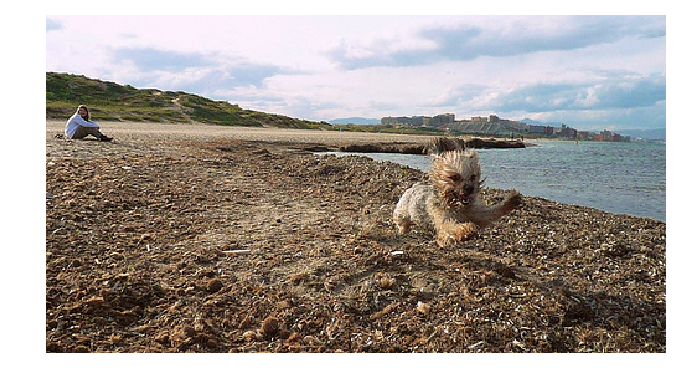


Ground truth: 

 A woman sitting on the sand at the beach , with a furry animal in the foreground walking towards her .
 A small furry brown dog is running on the shore of the ocean .
 a brown dog running along the dirt shore of a stream
 Dog running away from woman on the seashore .
 A small dog running on a beach .

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
a man in a red shirt and black pants is walking up a brick ramp


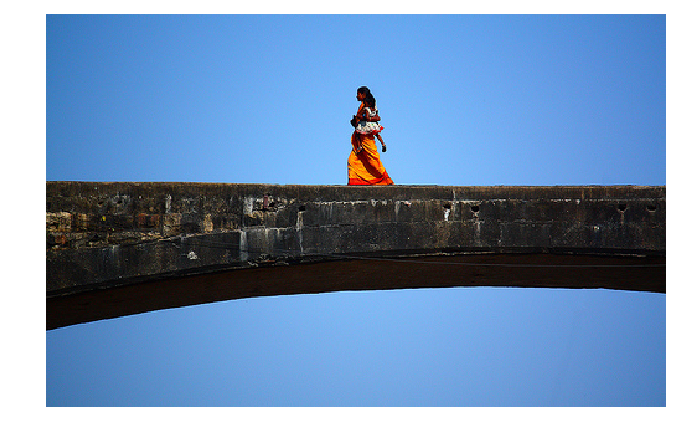


Ground truth: 

 A woman in an orange dress walking across a stone bridge with a very blue sky behind her .
 Woman in an orange skirt walking on concrete bridge .
 A woman in a dress is crossing a suspended bridge .
 A woman is carrying a child across a stone bridge .
 Woman in a dress walking across a bridge .

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
A black and white dog is chasing a ball .


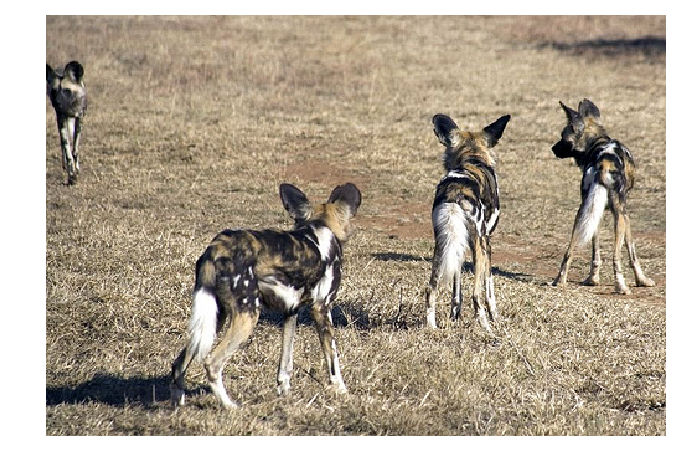


Ground truth: 

 A group of coyotes look away from the camera while standing in a dry field .
 Four multicolored dog like animals in a dryed grass field .
 prarie dogs that are spotted with , brown black and white
 Four dogs are standing in a dry grassy field .
 Four wild dogs in a dry field .

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
A man in a red shirt is sitting on a motorcycle .


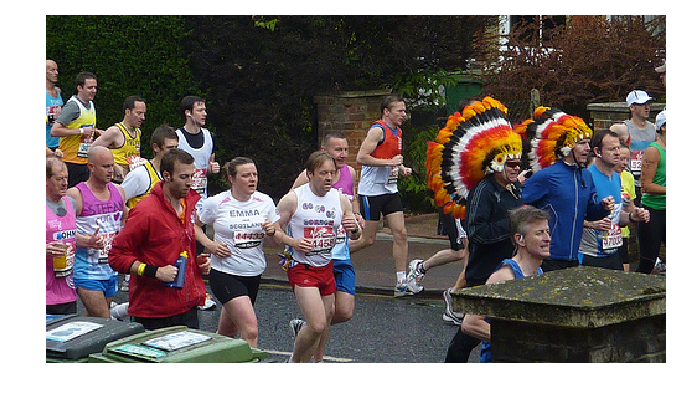


Ground truth: 

 Many people are running together in a marathon , two people in the front have Indian headdresses on .
 A group of people are running , and some of the runners are wearing the Native Americans headdress .
 Many men are running in a type of race , two of the men are wearing Indian headdresses .
 People running in a race , two of them are wearing brightly colored Indian headdresses .
 A crowd of people are running in a race .

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
A group of people are standing on a field .


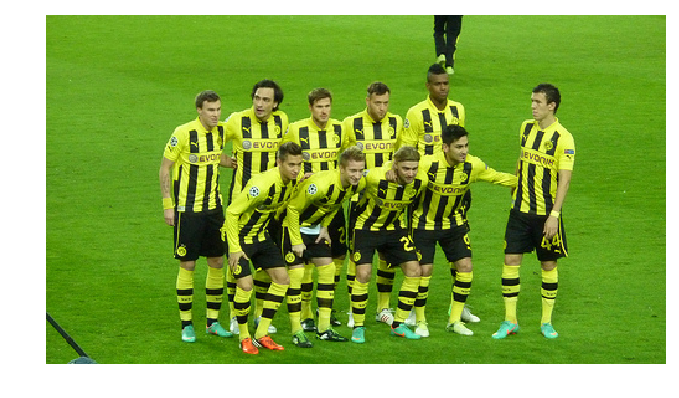


Ground truth: 

 A soccer team in yellow and black uniforms poses for a picture on the field .
 The soccer team is assembled on the field , and their uniforms are yellow .
 A soccer team in neon colors get ready to play on the bright green field .
 A group of ten men in yellow soccer uniforms pose for a picture .
 Soccer team excited and ready to take the ball for their team .

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
a man in a blue shirt and jeans is walking with a woman in a


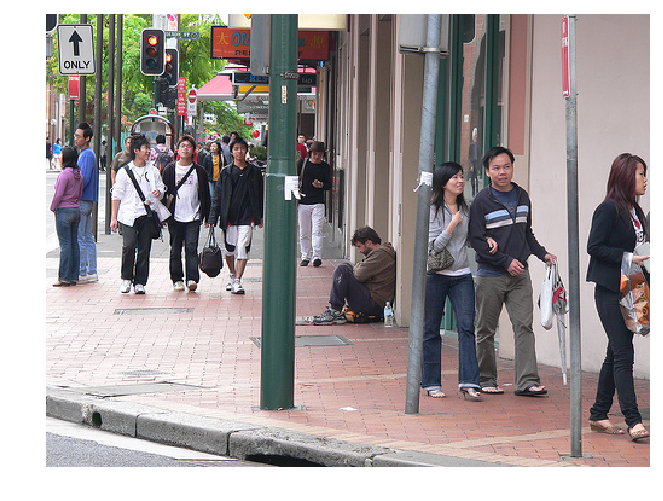


Ground truth: 

 A group of Asian men and women talk to each other as they walk down a busy street corner .
 A man sits on the sidewalk in front of an Asian restaurant as people pass .
 Many people are walking or standing on a busy city sidewalk .
 Downtown shoppers passing by homeless man .
 A man sitting on a busy sidewalk .

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
A man in a white shirt is standing in the grass .


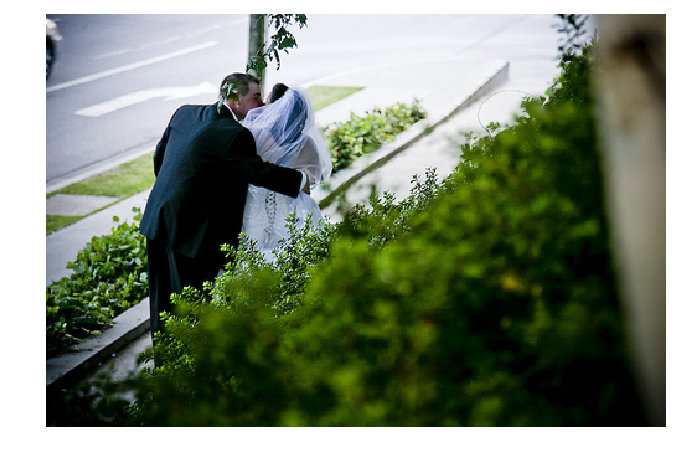


Ground truth: 

 A man in a dark suit is kissing a woman in a wedding dress on a sidewalk just beyond a wall of green shrubbery .
 A just married bride and groom walking down the sidewalk , having an intimate moment .
 A bride and groom are sharing a kiss on a sidewalk .
 A man kisses a bride as they walk down the street .
 A man and woman kissing on their wedding day .

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
a man in a red shirt and a woman in a red dress are playing


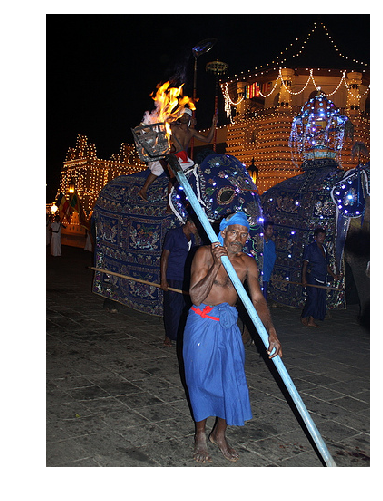


Ground truth: 

 Native man in blue garb holds flaming torch on long pole in advance of a pair of decorated marching elephants .
 Man with long pole that has a basket of fire on the tip outside in front of two elephants .
 A black man with no shirt is carrying a torch in front of bedazzled elephants .
 A shirtless man in blue holding up a large blue rod and looking at the camera .
 barefoot man holding a long torch at a festival

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
A dog is running through a field with a ball in his mouth .


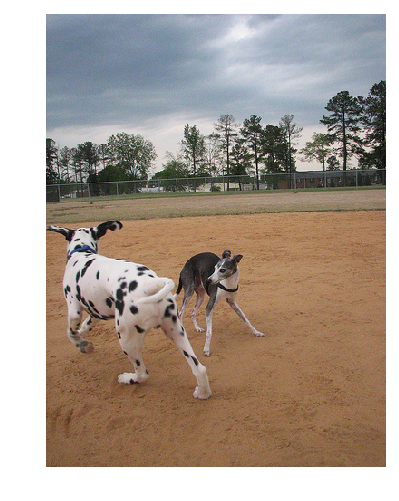


Ground truth: 

 A black and white spotted dog is circling a gray and white dog .
 A spotted dog playing on a baseball field with another dog .
 Two dogs are running around each other in the sand .
 two dogs play on a baseball field .
 Two dogs play in a sandy field .

--------------------------------------------------------------
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1786
A man in a black shirt is jumping in the air .


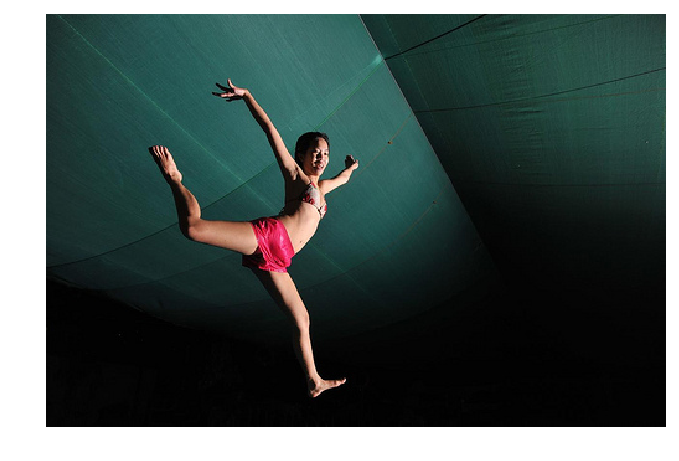


Ground truth: 

 A woman appears frozen in mid-jump with her arms and legs splayed wide with a plain background .
 A woman , dressed in pink shorts and a bikini top , is leaping .
 A woman in fuchsia shorts and a bra top is leaping in the air .
 A woman wearing pink shorts leaps in the air .
 Woman reaching new heights .


In [21]:
for idx in test_image_idxs:
    print('\n--------------------------------------------------------------')
    test(sess, image, generated_words, ixtoword, idx)
    show_image(os.path.join(flickr_30k_path, images[idx]))
    print('\nGround truth: \n')
    for s in capt_per_img[images[idx]]:
        print(' {}'.format(s))